In [16]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import random

In [17]:
sns.set_style("whitegrid")
random.seed(42)

In [18]:
# defining notebook parameters
name_dataset = "2022_08_30/track_2022_08_30.csv"
date_download = datetime.datetime(2022, 8, 30)
data_folder = "2022_08_30"
# Change for data creation!
too_popular = False

In [19]:
# reading file 
df = pd.read_csv(name_dataset)

In [20]:
df.columns

Index(['name', 'track_id', 'artist', 'artist_id', 'track_popularity',
       'artist_popularity', 'artist_total_followers', 'release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature'],
      dtype='object')

In [21]:
# remove unnecessary columns
df = df.drop(["track_id", "artist_id", "type", "uri", "track_href", "analysis_url"], axis=1)

## Preprocessing

In [22]:
initial_rows = len(df)
print(f"Initial rows : {initial_rows}")

Initial rows : 61173


In [23]:
# transforming the strings to datetime (for release date)
df['release_date'] = pd.to_datetime(df['release_date'])

# removing songs that have non relevant release-date
df = df[df['release_date'] < date_download] 
df = df[df['release_date'] > datetime.datetime(2022, 1, 1)]

# removing non-relevant songs (comment this out when analysing recency and non-popularity)
df = df[df['track_popularity'] !=0] 

# remove too popular artists (analysing the non popular artists more indie ...)
if too_popular:
       df = df[(df['artist_total_followers'] < 100000)]

# normalize numeric continous features
numeric_features = ['artist_popularity', 'artist_total_followers',
       'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']

df[numeric_features] = df[numeric_features].apply(lambda x: (x-x.mean())/ x.std())

In [24]:
after_prep_rows = len(df)
print(f"After preprocessing rows : {after_prep_rows}")

After preprocessing rows : 49366


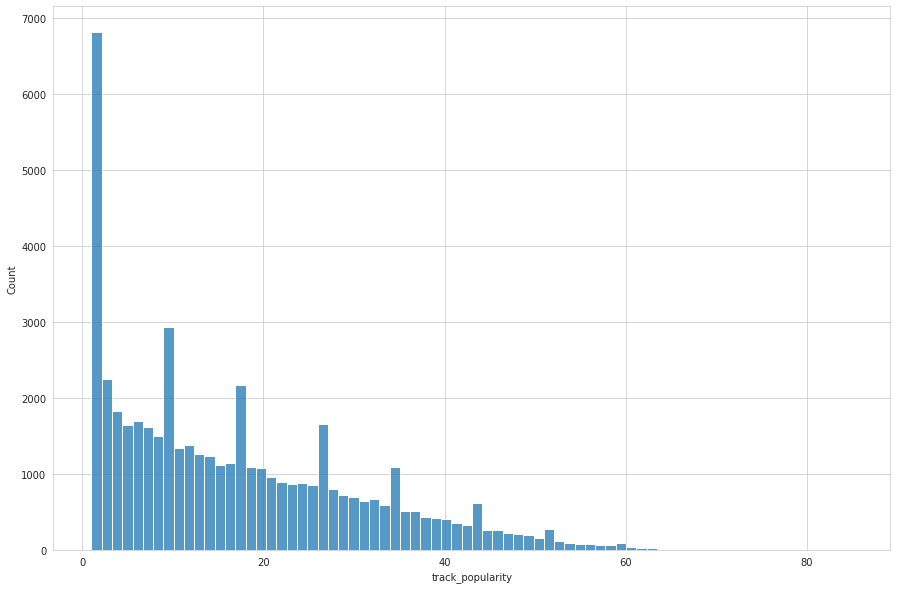

In [25]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df, x='track_popularity')
plt.show()

## Feature creation

### Hit or Non-hit

In [26]:
initial_rows = len(df)
print(f"Initial rows : {initial_rows}")

Initial rows : 49366


In [27]:
# create non-hit hit song
df = df.sort_values(by="track_popularity", ascending=False)
df = df.reset_index(drop=True)

split_index = int(len(df)*0.1)

# selecting the hit songs
hits = df.iloc[:split_index]
hits['hit'] = "TRUE"

# selecting the non-hit songs
non_hits = df.iloc[split_index:]
non_hits = non_hits.sample(len(hits))
non_hits['hit'] = "FALSE"

# concatetening the dataframes
df = pd.concat([hits, non_hits], axis=0, ignore_index=True)

/tmp/ipykernel_29458/1087404638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['hit'] = "TRUE"


In [31]:
after_prep_rows = len(df)
print(f"After preprocessing rows : {after_prep_rows}")

After preprocessing rows : 9872


### Key transformation to string

In [32]:
key_options = {
    0 : "C",
    1 : "C_sharp",
    2 : "D",
    3 : "D_sharp",
    4 : "E",
    5 : "F",
    6 : "F_sharp",
    7 : "G",
    8 : "G_sharp",
    9 : "A",
    10: "A_sharp",
    11: "B",
}

def transform_key(key):
    return key_options[key]

df["key"] = df["key"].apply(transform_key)

### Mode to strings

In [33]:
def transform_mode(mode):
    if mode == 0:
        return "minor"
    elif mode == 1:
        return "major"
    else:
        raise ValueError()

df["mode"] = df["mode"].apply(transform_mode)

### Time signature to string

In [34]:
def transform_time_signature(t):
    return str(t) + "/4"

df["time_signature"] = df["time_signature"].apply(transform_time_signature)

## Exporting the data for training

In [35]:
train, test = train_test_split(df, test_size=0.2)
print(f"The test dataset has the length {len(test)}")
print(f"The train dataset has the length {len(train)}")

The test dataset has the length 1975
The train dataset has the length 7897


In [36]:
# exporting the files
artist_kind = "_"
if too_popular:
    artist_kind += "Bounded_artists"
else:
    artist_kind += "All_artists"
train.to_csv(f"{data_folder}/train{artist_kind}.csv", index=False)
test.to_csv(f"{data_folder}/test{artist_kind}.csv", index=False)

In [37]:
# Run until here for data creation!

## Correlation between numeric variables

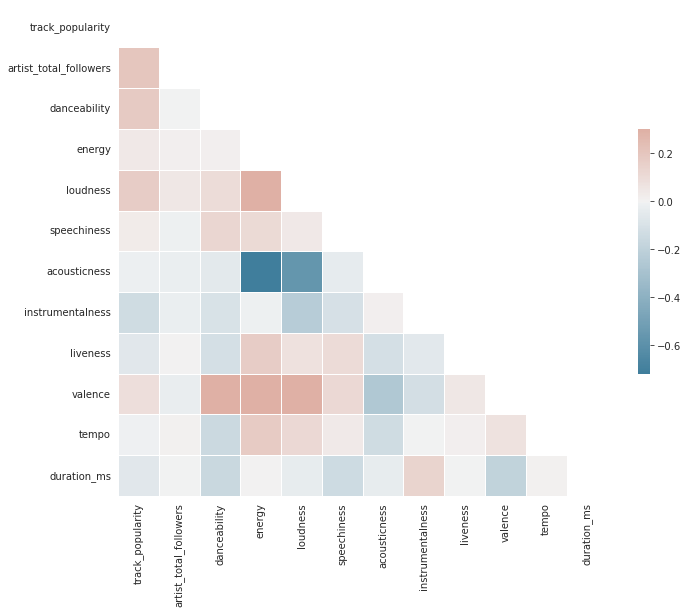

In [38]:
# selecting the numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics).drop(["artist_popularity"], axis=1)

# calculating correlation matrix
corr = numeric_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("../Figures/correlation_map.png")
plt.show()

## Answering the question if popularity 0 is just because of recent songs

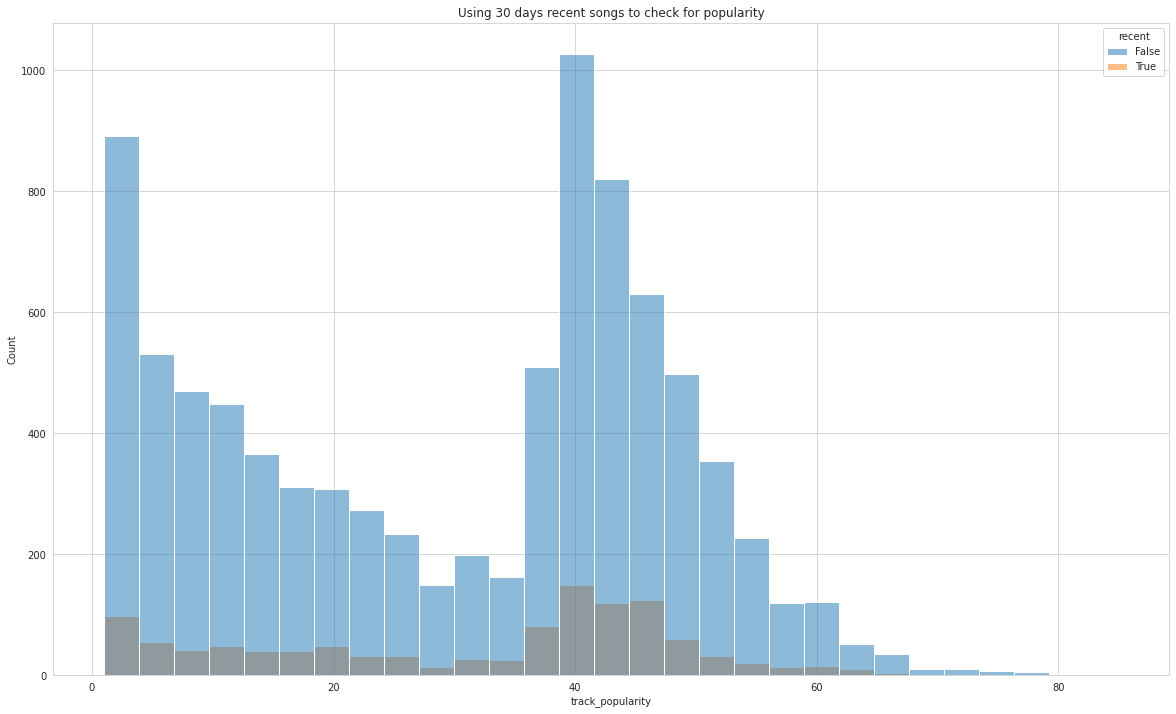

In [39]:
# defining when is a song not recent anymore
recent_songs_delta = 30 # days

# sorting values (not necessary)
df = df.sort_values(by=["release_date"], ascending=False) 

# custom function for checking the 
def is_recent(d):
    if (date_download - d).days < recent_songs_delta:
        return True      
    else:
        return False

df['recent'] = df['release_date'].apply(is_recent)

plt.figure(figsize=(20,12))
plt.title("Using 30 days recent songs to check for popularity")
sns.histplot(data=df, x="track_popularity", hue="recent")
plt.show()

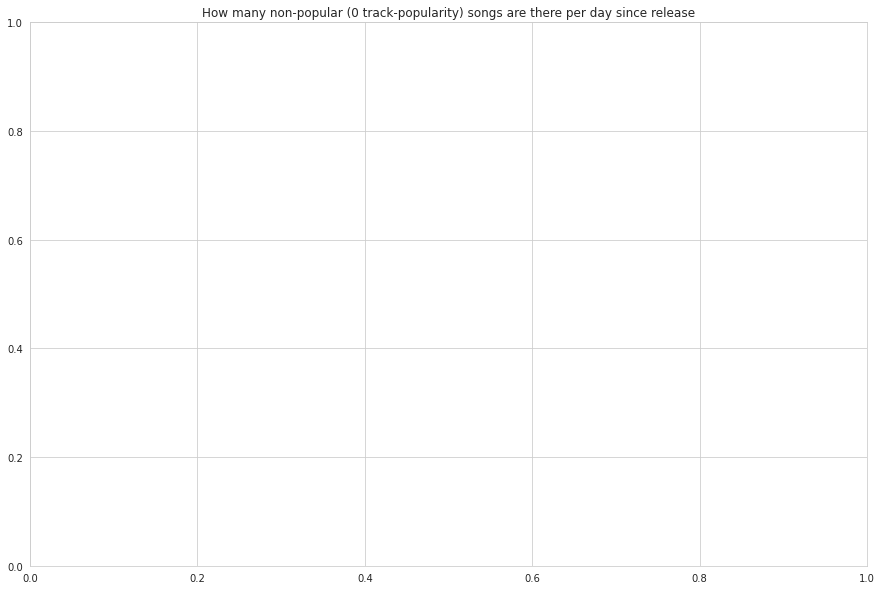

In [40]:
def since_release(t):
    return (date_download-t).days

df['days_since_release'] = df['release_date'].apply(since_release)

df_sample = df[(df['days_since_release'] < recent_songs_delta) & (df['track_popularity'] == 0)]

plt.figure(figsize=(15, 10))
plt.title("How many non-popular (0 track-popularity) songs are there per day since release")
sns.histplot(data=df_sample, x="days_since_release", bins=30)
plt.show()


## Analysing the distribution of the musical features

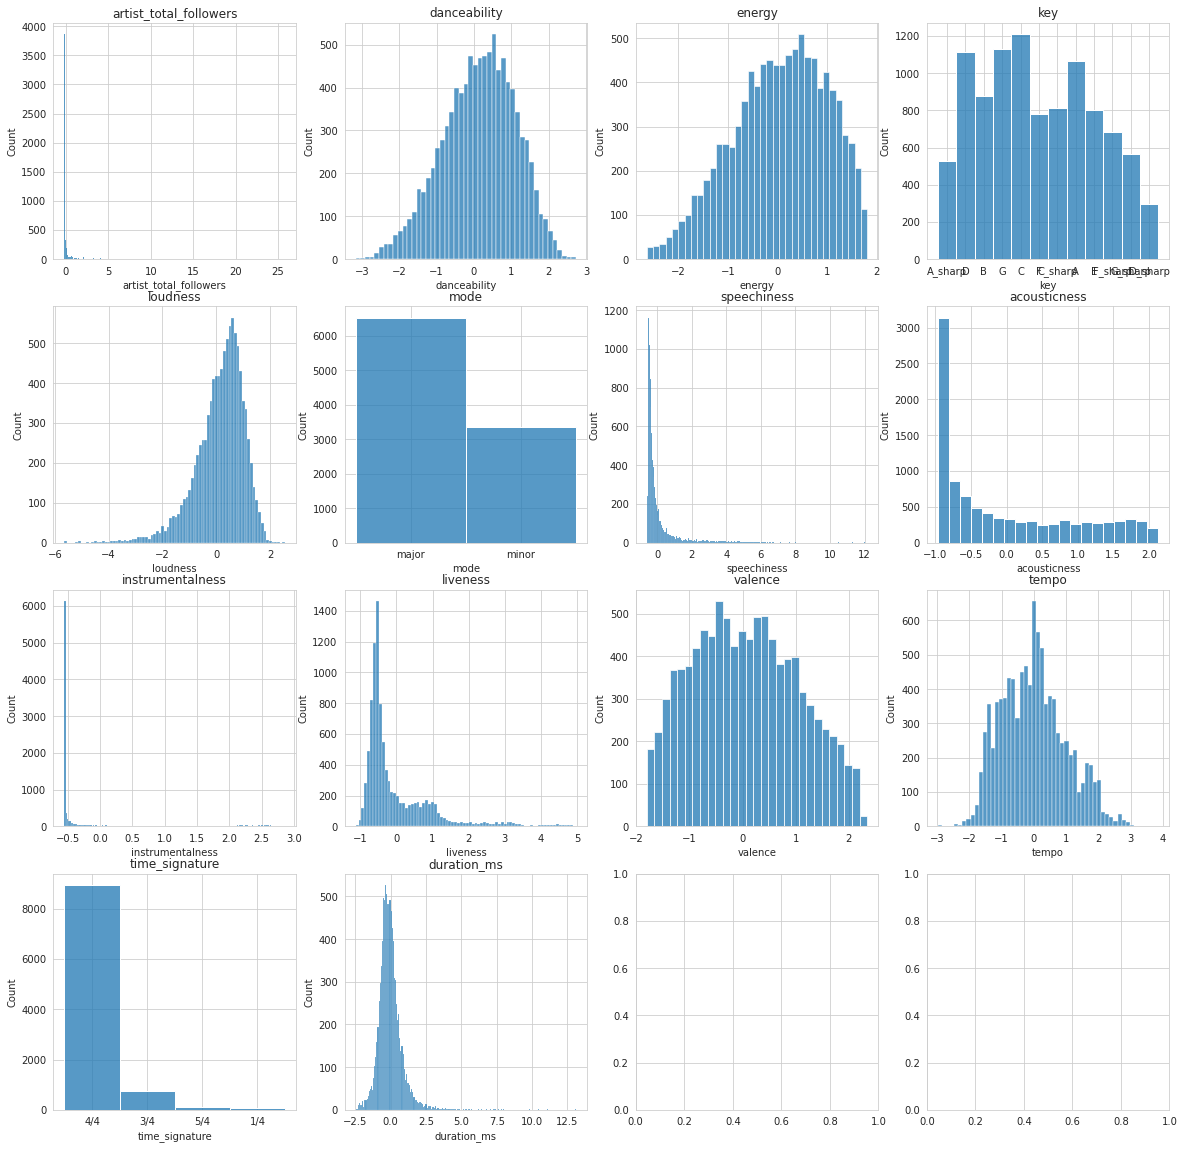

In [41]:
musical_features = ['artist_total_followers', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', "time_signature", "duration_ms"]

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for index, m in enumerate(musical_features):
    coord = int(index/4), index%4
    axs[coord].set_title(m)
    sns.histplot(data=df, x=m, ax=axs[coord])

plt.savefig("../Figures/distribution_features.png")
plt.show()